Dataset processing

In [0]:
%%time
import pandas as pd
import numpy as np

head = ["user", "rating", "date"]
# Netflix prize dataset: https://www.kaggle.com/netflix-inc/netflix-prize-data
path = "netflix/combined_data_1.txt"

df = pd.read_table(path, names=head, delimiter=',')

# items indices
inds = pd.isnull(df).any(1).nonzero()[0]
# items column generation
items = []
for i in range(inds.size):
    dist = inds[i + 1] - inds[i] if i + 1 < inds.size \
                                else df.shape[0] - inds[i]
    items += [int(df.iloc[inds[i], 0][:-1])] * dist
df["item"] = items
# drop only-item rows, e.g. \d+:
df = df.drop(inds, axis=0)

df["date"] = pd.to_datetime(df["date"])
max_date = pd.to_datetime("2006-02-01")
# number of months
df["date"] = ((max_date - df["date"]) / np.timedelta64(1, 'M')).apply(int)

# renumbering users sequentially
df["user"] = df["user"].rank(method="dense").apply(int)

df.to_hdf("dataset.h5", key='df', mode='w')

CPU times: user 2min 44s, sys: 15.9 s, total: 3min
Wall time: 9min 54s


Loading processed dataset

In [0]:
%%time
import pandas as pd

dataset = "dataset.h5"
df = pd.read_hdf(dataset, "df")

CPU times: user 10.9 ms, sys: 442 ms, total: 453 ms
Wall time: 2.77 s


In [0]:
%%time
import numpy as np
# validation set objects (last month)
inds_v = np.where(df["date"] == 1)[0]
print("Validation set size: {}".format(len(inds_v)))
# train and test
inds_l = np.where(df["date"] != 1)[0]

Validation set size: 462232
CPU times: user 173 ms, sys: 75.3 ms, total: 249 ms
Wall time: 952 ms


Sparse matrix generation

In [0]:
%%time
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, save_npz

dataset = "dataset.h5"
df = pd.read_hdf(dataset, "df")

# rows number in sparse matrix
# same as objects number
rows = df.shape[0]

max_u = df["user"].max()
max_i = df["item"].max()
# columns number in sparse matrix
# given users and items were numbered sequentially
cols = max_u + max_i + 1

# nonzero row indices
i = list(range(rows)) * 3

# nonzero column indices
j = (df["user"] - 1).append(df["item"] + max_u - 1).values
j = np.hstack((j, [max_u + max_i] * rows))

# nonzero matrix cells
values = np.hstack((np.ones(rows * 2), df["date"].values))

X_sparse = csr_matrix((values, (i, j)), shape=(rows, cols))
save_npz("X.npz", X_sparse)

# ratings
df["rating"].to_hdf("y.h5", key='y', mode='w')

CPU times: user 42 s, sys: 3.28 s, total: 45.3 s
Wall time: 2min 16s


Prediction

In [0]:
def lin(w0, W, X):
    return w0 + X.dot(W)

def interactions(V, X):
    f = V.shape[1]
    # for summing via matrix-vector product
    ones_f = np.ones((f, 1))
    
    Z = X.dot(V)
    X2 = X.power(2)
    V2 = np.square(V)
    Z2 = X2.dot(V2)
    nonlinear = 0.5 * (np.square(Z) - Z2).dot(ones_f)
    return nonlinear, Z

def predict(w0, W, V, X):
    l = lin(w0, W, X)
    i, Z = interactions(V, X)
    return l + i, Z

Quality

In [0]:
def eps(y_pred, y):
    return y_pred - y

def mse(y_pred, y):
    e = eps(y_pred, y)
    return 1 / e.shape[0] * e.T.dot(e)
    
def rmse(y_pred, y):
    return np.sqrt(mse(y_pred, y))

def r2(y_pred, y):
    e = eps(y_pred, y)
    residual = e.T.dot(e)
    t = y - np.mean(y)
    total = t.T.dot(t)
    return (1 - residual / total)[0, 0]

def evaluate(w0, W, V, X, y):
    y_hat, Z = predict(w0, W, V, X)
    rmse_ = rmse(y_hat, y)
    r2_ = r2(y_hat, y)
    return y_hat, rmse_, r2_

Some functions

In [0]:
from scipy.sparse import diags
# parameter update via mini-batch GD
def update(eta, w0, W, V, X, y, y_pred, Z):
    e = eps(y_pred, y)
    w0 = w0 - eta[0] * 2 * np.mean(e)
    
    X_eps = X.transpose().dot(e)
    W = W - eta[1] * 2 / X.shape[0] * X_eps
        
    X_eps_d = X.transpose().dot(diags(e.T[0]))
    X2 = X.power(2)
    X2_eps = X2.transpose().dot(e)
    V = V - eta[2] * 2 / X.shape[0] * (X_eps_d.dot(Z) - 
                                        diags(X2_eps.transpose()[0], shape=(d, d)).dot(V))
    return w0, W, V

Sparse matrix loading

In [0]:
%%time
import numpy as np
import pandas as pd
from scipy.sparse import load_npz

X = load_npz("X.npz")

y = pd.read_hdf("y.h5").values
y = y[:, np.newaxis]

# validation set
X_v = X[inds_v[:3000]]
y_v = y[inds_v[:3000]]

# train & test
X = X[inds_l]
y = y[inds_l]

# m - objects number
# d - features number
m, d = X.shape
# fct - factors number
fct = 8

CPU times: user 5.86 s, sys: 2.29 s, total: 8.16 s
Wall time: 4min 55s


Batch size selection

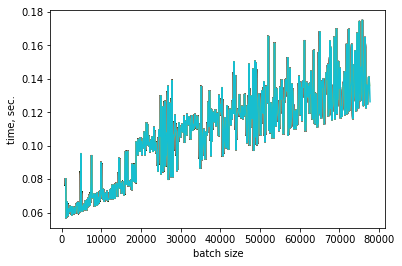

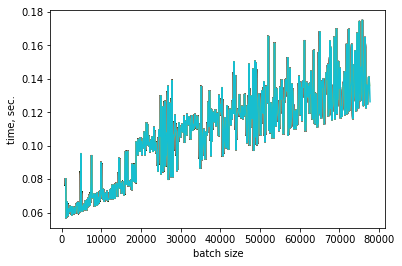

In [0]:
%matplotlib inline
import time
import pylab as pl
from IPython import display

# bias
w0 = 0
# weights vector
W = np.zeros((d, 1))
# factors matrix
V = np.random.rand(d, fct)
# learning rate (w_0, W, V)
eta = [0.1, 0.001, 0.0003]

t = []
batch_sz = []
i = 0
b = 1024
while i < m:
    start = time.time()
    
    if i + b <= m:
        X_b = X[i:i+b]
        y_b = y[i:i+b]
    else:
        X_b = X[i:m]
        y_b = y[i:m]
            
    # prediction on batch
    y_hat, Z = predict(w0, W, V, X_b)
            
    # update
    w0, W, V = update(eta, w0, W, V, X_b, y_b, y_hat, Z)
    
    stop = time.time()
    t.append(stop - start)
    batch_sz.append(b)
    i += b
    b += 128
    
    pl.plot(batch_sz, t)
    display.clear_output(wait=True)
    pl.xlabel('batch size')
    pl.ylabel('time, sec.')
    # pl.xticks(batch_sz)
    display.display(pl.gcf())
    time.sleep(1.0)


Parameter initialization

In [0]:
from sklearn.model_selection import KFold
folds = 5
kf = KFold(n_splits=folds, shuffle=True)

# batch size
b = 4000

# max full sample passes
MAX_IT = 5

rmse_train = []
rmse_test = []
r2_train = []
r2_test = []

In [ ]:
from ipywidgets import IntProgress
from IPython.display import display
import time


# progress bar for folds
fold = IntProgress(min=0, max=folds, step=1, description='Folds:', value=0)
display(fold)

# progress bar for iterations
iterations = IntProgress(min=0, max=MAX_IT, step=1, description='Iterations:', value=0)
display(iterations)

# progress bar for batch
batch = IntProgress(min=0, max=m, step=b, description='Sample:', value=0)
display(batch)

# curent result on validation set
r2_v2 = 0
rmse_v2 = 0
y_hat_v2 = np.zeros((y_v.shape[0], 1))
for train, test in kf.split(X):
    # bias
    w0 = 0
    # weights vector
    W = np.zeros((d, 1))
    # factors matrix
    V = np.random.rand(d, fct)
    
    # learning rate (w_0, W, V)
    eta = [0.1, 0.001, 0.0003]
    
    # passes through the sample
    it = 0
    iterations.value = 0
    # one fold
    while True:
        np.random.shuffle(train)
        batch.value = 0
        start = time.time()
        # one full pass through the training set with step b
        for i in range(0, train.size, b):
            if i + b <= train.size:
                X_b = X[train[i:i+b]]
                y_b = y[train[i:i+b]]
            else:
                X_b = X[train[i:train.size]]
                y_b = y[train[i:train.size]]
                
            # prediction on batch
            y_hat, Z = predict(w0, W, V, X_b)
            # update
            w0, W, V = update(eta, w0, W, V, X_b, y_b, y_hat, Z)
            # prediction on validation set after update
            y_hat_v1, rmse_v1, r2_v1 = y_hat_v2, rmse_v2, r2_v2
            y_hat_v2, rmse_v2, r2_v2 = evaluate(w0, W, V, X_v, y_v)
            
            # possible stop 1 (no difference between predictions on validation set after update)
            #if np.mean(np.abs(y_hat_v1 - y_hat_v2)) < 10**-20:
                # for exit from outer loop
                # it = MAX_IT-1
                # break
             # performance check
            if (i + b) % 100 == 0:
                print("After learning on {} objects: RMSE_valid = {}, R2_valid={}".format(i, rmse_v2, r2_v2))


            # learning rate decreasing
            if rmse_v2 > rmse_v1:
                eta[0] /= 2
                eta[1] /= 2
                eta[2] /= 2
            elif rmse_v1 < rmse_v2:
                eta[0] += 0.05 * eta[0]
                eta[1] += 0.05 * eta[1]
                eta[2] += 0.05 * eta[2]

            batch.value += b

        stop = time.time()
        print("Full sample processing time: {} min.".format((stop - start) / 60))
        it += 1
        # increment iterations progress bar
        iterations.value += 1
        
        # possible stop 2
        if it == MAX_IT:
            np.random.shuffle(train)
            y_train, rmse_train_, r2_train_ = evaluate(w0, W, V, X[train[:10000]], y[train[:10000]])
            y_test, rmse_test_, r2_test_ = evaluate(w0, W, V, X[test[:10000]], y[test[:10000]])
            
            rmse_train.append(rmse_train_)
            rmse_test.append(rmse_test_)

            r2_train.append(r2_train_)
            r2_test.append(r2_test_)
            break
    # increment the fold progress bar
    fold.value += 1

In [0]:
print(rmse_train)
print(rmse_test)

[array([[4.26863188]]), array([[3.76715575]]), array([[3.43111266]]), array([[3.20372773]]), array([[3.81279074]])]
[array([[3.63991284]]), array([[3.25530589]]), array([[3.43558679]]), array([[2.80778652]]), array([[3.02646492]])]


In [0]:
rmse_train_ = np.append(rmse_train, [np.mean(rmse_train), np.std(rmse_train)])
rmse_test_ = np.append(rmse_test, [np.mean(rmse_test), np.std(rmse_test)])

r2_train_ = np.append(r2_train, [np.mean(r2_train), np.std(r2_train)])
r2_test_ = np.append(r2_test, [np.mean(r2_test), np.std(r2_test)])

tmp = [rmse_train_, rmse_test_, r2_train_, r2_test_]

res = pd.DataFrame(columns=["1", "2", "3", "4", "5", "Mean", "Std"], data=tmp)
df.insert(loc=0, column="Fold No.", value=["RMSE train", "RMSE test", "R2 train", "R2 test"])
print(res)